In [54]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import mplleaflet
import mpl_toolkits
import folium

In [ ]:
# Read the shapefile you can download from this repo https://github.com/gweissman86/three_digit_zips
us_3zip = gpd.read_file("/Users/<USER_NAME>/GitHub/three_digit_zips/three_dig_zips/three_dig_zips.shp")
us_3zip.head()

,3dig_zip,geometry
0,032,"POLYGON ((-71.66777 43.15253, -71.6349 43.0335..."
1,033,"POLYGON ((-71.62792 43.16028, -71.60296 43.165..."
2,034,"POLYGON ((-71.94428 42.78841, -71.92902 42.712..."
3,035,"POLYGON ((-71.53762 44.1975, -71.58151 44.1120..."
4,281,"MULTIPOLYGON (((-79.96892 34.80745, -80.79754 ..."


<Axes: >

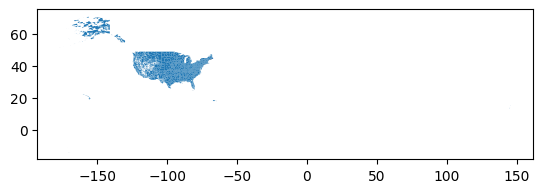

In [56]:
us_3zip.plot()

In [ ]:
# reduce axis to only see CONUS
x1, y1, x2, y2 = (-130, 20, -50, 50)
us_3zip_conus = us_3zip[
    (us_3zip.centroid.x > x1)
    & (us_3zip.centroid.y > y1)
    & (us_3zip.centroid.x < x2)
    & (us_3zip.centroid.y < y2)
]

<Axes: >

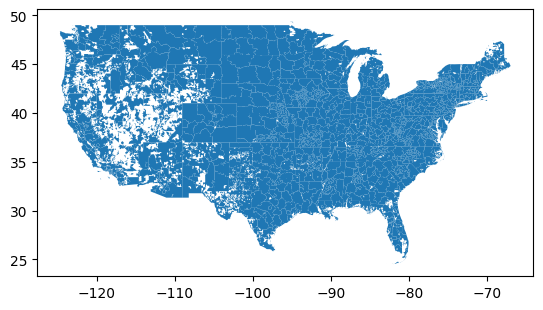

In [58]:
us_3zip_conus.plot()

In [ ]:
# get centroids and use at lat long
us_3zip_conus['lat'], us_3zip_conus['long'] = us_3zip_conus.centroid.y, us_3zip_conus.centroid.x
us_3zip_conus = us_3zip_conus.drop(columns=['geometry'])
us_3zip_conus.head()

In [60]:
us_3zip_conus['3dig_zip']

0      032
1      033
2      034
3      035
4      281
      ... 
891    156
892    036
893    037
894    038
895    039
Name: 3dig_zip, Length: 884, dtype: object

In [61]:
# make a fake dataset
index = pd.MultiIndex.from_product([us_3zip_conus['3dig_zip'],us_3zip_conus['3dig_zip']], names = ["org", "dest"])

fake_data = pd.DataFrame(index = index).reset_index()
fake_data = fake_data[fake_data['org'] != fake_data['dest']]

# add fake vol per week
fake_data['vol_per_week'] = np.random.randint(1, 11, size=len(fake_data))
fake_data.head()


,org,dest,vol_per_week
1,032,033,10
2,032,034,2
3,032,035,9
4,032,281,4
5,032,282,3


In [62]:
#remove cartesian product while summing columns 
fake_data[['org','dest']] = pd.DataFrame(np.sort(fake_data[['org','dest']].values, axis=1))
fake_data = fake_data.groupby(['org', 'dest']).vol_per_week.sum().reset_index()
fake_data.shape

(390286, 3)

In [63]:
# Lets sample this to make it more realistic
df_sample = fake_data.sample(frac=0.005, random_state=42)
df_sample.shape

(1951, 3)

In [64]:
# make our network X from fake data
# load the nodes and edges
G = nx.from_pandas_edgelist(df_sample, 
                            'org', 
                            'dest',
                            'vol_per_week')

#get edge weights
widths = nx.get_edge_attributes(G, 'vol_per_week')

#get degree
# Calculate node degrees
node_degrees = dict(G.degree())

# Set node size based on degree
node_sizes = [node_degrees[node] * 5 for node in G.nodes()]

pos = us_3zip_conus[['3dig_zip','long','lat']].set_index('3dig_zip').T.to_dict('list')


In [65]:
# in mac you need to export geo library before install
# export GEOS_DIR=/opt/homebrew/Cellar/geos/3.13.0
from mpl_toolkits.basemap import Basemap as Basemap


In [66]:
plt.figure(figsize = (10,10))

basemap = Basemap(
    projection = 'merc',
    llcrnrlon = -125, 
    urcrnrlon = -70,     
    llcrnrlat = 25,  
    urcrnrlat = 50,    
    lat_ts = 0,
    resolution = 'l',
    suppress_ticks = True)

<Figure size 1000x1000 with 0 Axes>

In [67]:
basemap_x, basemap_y = basemap(us_3zip_conus['long'].values, 
                               us_3zip_conus['lat'].values)

pos = {}
for i, zip in enumerate (us_3zip_conus['3dig_zip']):    
    pos[zip] = (basemap_x[i], basemap_y[i])

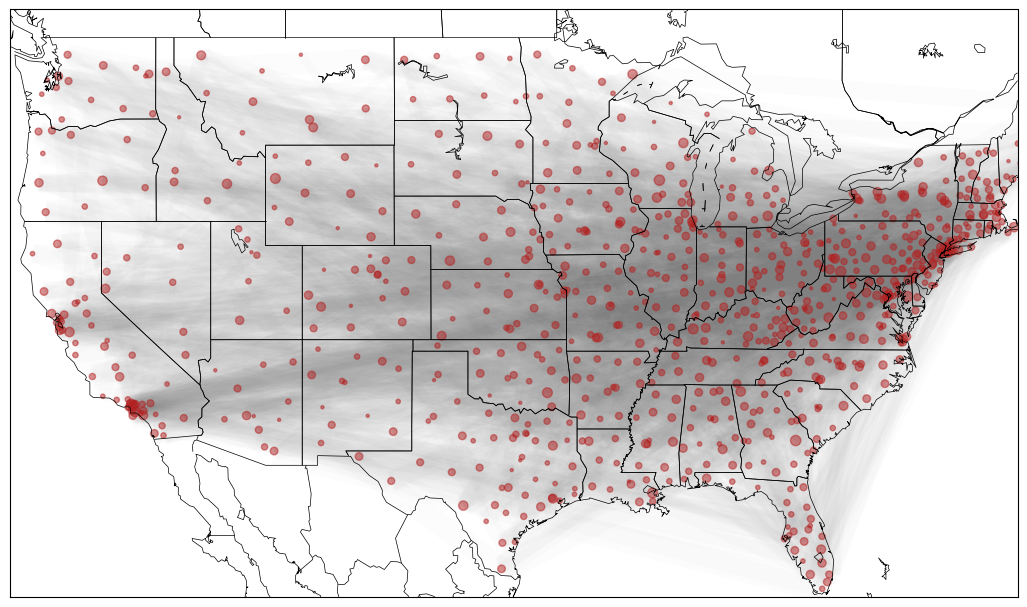

In [102]:
ax = plt.figure(figsize=(13, 13))


nx.draw_networkx_nodes(G = G, 
                       pos = pos, 
                       nodelist = G.nodes(), 
                       node_color = 'firebrick', 
                       alpha = 0.5, 
                       node_size = node_sizes
                       )

# based on edge width
nx.draw_networkx_edges(G = G, 
                       pos = pos, 
                       edge_color='grey',
                       alpha=0.02, 
                       width=list(widths.values()),
                       arrows = False)

basemap.drawcoastlines(linewidth = 0.5)
basemap.drawstates(linewidth = 0.5)
basemap.drawcountries(linewidth = 0.5)


/var/folders/p_/rsfcf63x5hb0lb9h219g4nl40000gn/T/ipykernel_82047/1219823794.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


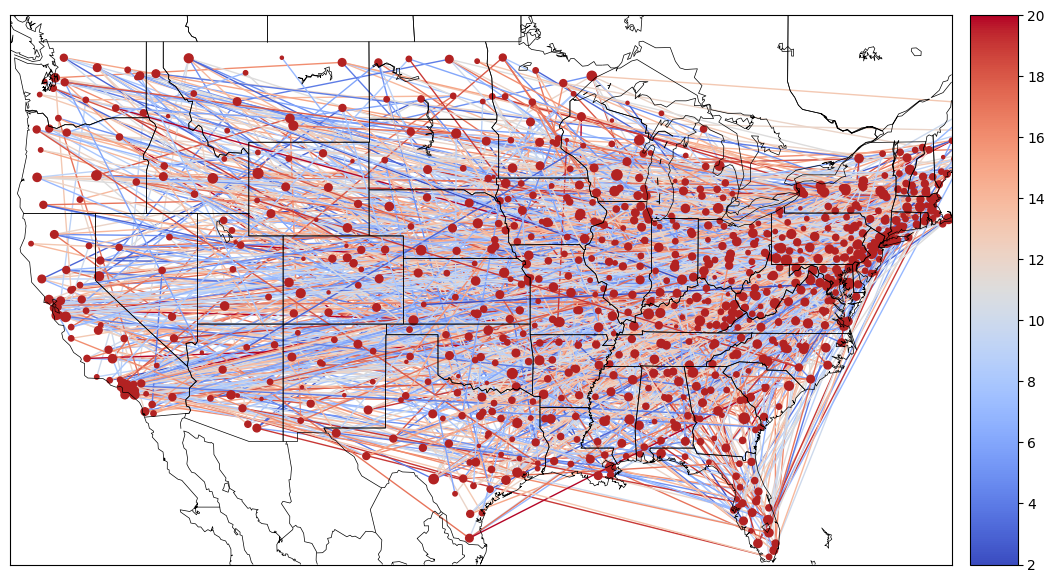

In [ ]:

ax = plt.figure(figsize=(13, 13))
cmap = plt.cm.get_cmap('coolwarm')




edges =  nx.draw_networkx_edges(G = G, 
                       pos = pos, 
                       edge_color = list(widths.values()),
                       width=1,
                       edge_cmap=cmap,
                       arrows = False)

nodes = nx.draw_networkx_nodes(G = G, 
                       pos = pos, 
                       nodelist = G.nodes(), 
                       node_color = 'firebrick', 

                       node_size = node_sizes
                       )

#color based off of weight
basemap.drawcoastlines(linewidth = 0.5)
basemap.drawstates(linewidth = 0.5)
basemap.drawcountries(linewidth = 0.5)

basemap.colorbar(edges)

## Let's make an interactive map in folium

In [202]:
# Need to update positions with real lat/longs instead of basemap conversion
pos2 = {}
pos2 = us_3zip_conus[['3dig_zip','lat','long']].set_index('3dig_zip').T.to_dict('list')


In [217]:
from folium.plugins import MarkerCluster
# Create a Folium map centered on the first node's coordinates
m = folium.Map(location=[us_3zip_conus.lat[0], us_3zip_conus.long[0]], zoom_start=5)

# # standard node and edges
# # Add nodes to the map
# for node, coords in pos2.items():
#     folium.Marker(coords, popup=f"Node {node} {coords}").add_to(m)
    
# # Add edges to the map
# for u, v in G.edges():
#     folium.PolyLine([pos2[u], pos2[v]], color="blue", weight=2.5, opacity=.05).add_to(m)

marker_cluster = MarkerCluster().add_to(m)
# Add edges to the map
for i, val in enumerate(G.edges()):
    folium.PolyLine([pos2[val[0]], pos2[val[1]]],
                    color="blue",
                    weight=list(widths.values())[i]/3,
                    opacity=.1,
                    popup=f"{val[0]} to {val[1]} volume: {list(widths.values())[i]}"
                    ).add_to(m)

# Add nodes to the map
for i, val in enumerate(G.nodes()):
    folium.CircleMarker(location=pos2[val],
                        radius=(node_sizes[i])/3,
                        color="black",
                        weight=1,
                        fill_opacity=0.6,
                        opacity=1,
                        fill_color="green",
                        fill=False, 
                        popup=f"Three digit zip: {val} connections: {node_sizes[i]}").add_to(m)
    



# Save the map as an HTML file
m.save("network_map.html")